In [1]:
import numpy as np
from src.extraction import calc_raz_out, calc_raz_out_strong, calc_raz_out_strong_qproof
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
font = {'family' : 'Helvetica',
        'size'   : 7}
mpl.rc('font', **font)

In [2]:
n = 64
L = 23651
n_quantum_in = L * n  # Length of the input to the 2-source extractor

varepsilon_ts = 10**-6  # Error of the extractor, i.e. the distance bound
varepsilon_2 = 10**-8
n_seed = 4093

# Good weak source $\alpha>0.5$

In [4]:
# ------- CR Amplification (Minimise entropy requirement of the quantum source) -------
# Minimise the min-entropy that needs to be certified from source of randomness
# subject to obtaining at-least 4093 bits of output after
# applying our efficiently implemented Raz' two-source extractor.

# Set n_1, the length of the weak (non CR) input source, as the
# largest supported field size for our efficient Raz's extractor:
# n_weakhalf = 74207281
n_weakhalf = 43112609
n_weak = n_weakhalf * 2  # Length of the extractor input from the weak
# source of randomness (in bits).

alphas = np.arange(0.5, 1, 0.001)[::-1]
betas = []
n_quantum = n_quantum_in
beta = 4094 / n_quantum + 0.001 # Initial min-entropy rate (it will be incremented in the loop).
# Set the min-entropy rate of the weak source of randomness (can be adjusted):
for alpha in tqdm(alphas):
    k_weak = np.floor(alpha * n_weak)  # Min-entropy of the weak source of randomness.

    
    # from the quantum computer (in bits).
    # n_2 = n_1half  # Maximum length of quantum input.
    assert n_quantum <= n_weak / 2, 'n_2 must be less than or equal to n_1 / 2'

    log2_error = np.log2(varepsilon_ts)  # Logarithm base 2 of the error of the extractor

    # Setting for the Raz extractor:
    strong = True
    qproof = True
    if strong and not qproof:
        calc = calc_raz_out_strong
    elif strong and qproof:
        calc = calc_raz_out_strong_qproof
    elif not strong and not qproof:
        calc = calc_raz_out

    # Compute the mininimum min-entropy rate of quantum source of randomness
    # required to obtain at least n_seed bits of output from the extractor.
    beta_step = 1.001
    result = None
    while True:
        beta *= beta_step  # Increment the min-entropy rate by 0.005 for each test.
        if beta > 1:
            break
        k_quantum = max(0, np.floor((beta - 10**-8) * n_quantum - np.log2(1 / varepsilon_2)))
        m_raz = n_seed  # Minimum output length required from the extractor.
        try:
            m_raz = calc(n_weak, k_weak, n_quantum, k_quantum, log2_error,
                                    m_init=m_raz, m_tests=1)
            if m_raz >= n_seed:
                betas.append(beta)
                beta /= beta_step
                result = True
                # print(beta, alpha)
                break
        except AssertionError:
            pass
    if result is None:
        betas.append(np.nan)

100%|██████████| 500/500 [00:01<00:00, 310.90it/s]


### Supplementary Fig. 8a

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


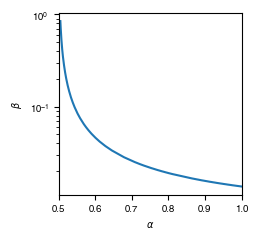

In [73]:
mm = 1/25.4  # millimeters in inches
plt.figure(figsize=(60 * mm, 60 * mm))
plt.plot(alphas, betas)
plt.xlim(0.5, 1)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')
plt.yscale('log')
# plt.savefig('good_weak_source.pdf')

# Bad weak source $\alpha<0.5$

For the experimentally output quantum randomness length, scan entropy rates that allow extraction assuming different levels of quantum entropy rate

In [5]:
# Currently supported field sizes for our efficient Raz's extractor:
valid_n1half = [
    3, 7, 15, 31, 63, 127, 255, 521, 1279, 2281, 3217, 4423, 23209,
    44497, 110503, 132049, 756839, 859433, 3021377, 6972593, 24036583,
    25964951, 30402457, 32582657, 42643801, 43112609, 74207281
]

varepsilon_ts = 10**-6  # Error of the extractor, i.e. the distance bound
log2_error = np.log2(varepsilon_ts)  # Logarithm base 2 of the error of the extractor

# Setting for the Raz extractor:
strong = True
qproof = True
if strong and not qproof:
    calc = calc_raz_out_strong
elif strong and qproof:
    calc = calc_raz_out_strong_qproof
elif not strong and not qproof:
    calc = calc_raz_out

n_quantum_prelim = 2 * min(x for x in valid_n1half if 2 * x >= n_quantum_in)
# (i.e. 0.5 + delta is the min-entropy rate when the QC source
# becomes the 'good' one). This will depend on how close n_qc
# is to a supported input size. For example, with the above
# parameters, if the rate of the qc is 0.53, a weaker min-entropy
# source can amplified when it is still considered the second source.

# The QC source is the 'good' source:
n_quantum = n_quantum_prelim  # Adjusted length of the QC input to the extractor.

n_weak = n_quantum_prelim // 2

# Compute the mininimum min-entropy rate of the weak source of randomness
# required to obtain at least 4093 bits of output from the extractor.
alphas = []
alpha = 4094 / n_weak # Initial min-entropy rate (it will be incremented in the loop).
alpha_step = 1.001

betas = np.arange(0.5, 1, 0.001)[::-1]
for beta in tqdm(betas):
    k_quantum = max(0, np.floor((beta - 10**-8) * n_quantum_in - np.log2(1 / varepsilon_2))) # Min-entropy of the input from the quantum computer.
    result = None

    while True:
        alpha *= alpha_step  # Increment the min-entropy rate by 0.005 for each test.
        if alpha > 1:
            break
        k_weak = np.floor(alpha * n_weak)
        m_raz = n_seed  # Minimum output length required from the extractor.
        try:
            m_raz = calc(n_quantum, k_quantum, n_weak, k_weak, log2_error,
                                    m_init=m_raz, m_tests=1)
            if m_raz >= n_seed:
                alphas.append(alpha)
                alpha /= alpha_step
                result = True
                # print(beta, alpha)
                break
        except AssertionError:
            pass
    if result is None:
        alphas.append(np.nan)

100%|██████████| 500/500 [00:01<00:00, 434.17it/s]


For experimentally output quantum randomness entropy rate $\beta=0.528$, scan the extractable weak source entropy rate.

In [6]:
# Currently supported field sizes for our efficient Raz's extractor:
valid_n1half = [
    3, 7, 15, 31, 63, 127, 255, 521, 1279, 2281, 3217, 4423, 23209,
    44497, 110503, 132049, 756839, 859433, 3021377, 6972593, 24036583,
    25964951, 30402457, 32582657, 42643801, 43112609, 74207281
]

varepsilon_ts = 10**-6  # Error of the extractor, i.e. the distance bound
log2_error = np.log2(varepsilon_ts)  # Logarithm base 2 of the error of the extractor

# Setting for the Raz extractor:
strong = True
qproof = True
if strong and not qproof:
    calc = calc_raz_out_strong
elif strong and qproof:
    calc = calc_raz_out_strong_qproof
elif not strong and not qproof:
    calc = calc_raz_out

alphas_vary_length = []
n_quantum_in_vary_length = []
for n1half in tqdm(valid_n1half):
    L_test = n1half * 2 // n
    n_quantum_in_test = L_test * n
    n_quantum_in_vary_length.append(n_quantum_in_test)
    n_quantum_prelim = 2 * min(x for x in valid_n1half if 2 * x >= n_quantum_in_test)
    # (i.e. 0.5 + delta is the min-entropy rate when the QC source
    # becomes the 'good' one). This will depend on how close n_qc
    # is to a supported input size. For example, with the above
    # parameters, if the rate of the qc is 0.53, a weaker min-entropy
    # source can amplified when it is still considered the second source.

    # The QC source is the 'good' source:
    n_quantum = n_quantum_prelim  # Adjusted length of the QC input to the extractor.

    n_weak = n_quantum_prelim // 2

    # Compute the mininimum min-entropy rate of the weak source of randomness
    # required to obtain at least 4093 bits of output from the extractor.
    alpha = 4094 / n_weak # Initial min-entropy rate (it will be incremented in the loop).
    alpha_step = 1.001

    beta = 0.528
    k_quantum = max(0, np.floor((beta - 10**-8) * n_quantum_in_test - np.log2(1 / varepsilon_2))) # Min-entropy of the input from the quantum computer.
    result = None

    while True:
        alpha *= alpha_step  # Increment the min-entropy rate by 0.005 for each test.
        if alpha > 1:
            break
        k_weak = np.floor(alpha * n_weak)
        m_raz = n_seed  # Minimum output length required from the extractor.
        try:
            m_raz = calc(n_quantum, k_quantum, n_weak, k_weak, log2_error,
                                    m_init=m_raz, m_tests=100)
            if m_raz >= n_seed:
                alphas_vary_length.append(alpha)
                alpha /= alpha_step
                result = True
                break
        except AssertionError:
            pass
    if result is None:
        alphas_vary_length.append(np.nan)

100%|██████████| 27/27 [00:11<00:00,  2.33it/s]


### Supplementary Fig. 8b

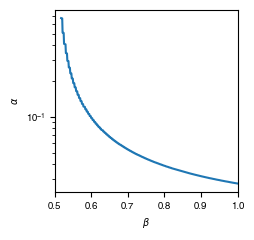

In [7]:
mm = 1/25.4  # millimeters in inches
plt.figure(figsize=(60 * mm, 60 * mm))
plt.plot(betas, alphas)
plt.xlim(0.5, 1)
plt.ylabel(r'$\alpha$')
plt.xlabel(r'$\beta$')
plt.yscale('log')
# plt.savefig('bad_weak_source.pdf')

### Supplementary Fig. 8c

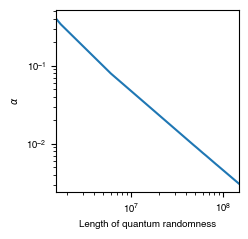

In [8]:
mm = 1/25.4  # millimeters in inches
plt.figure(figsize=(60 * mm, 60 * mm))
plt.plot(n_quantum_in_vary_length, alphas_vary_length)
plt.ylabel(r'$\alpha$')
plt.xlabel('Length of quantum randomness')
plt.xlim(L * n, max(n_quantum_in_vary_length))
plt.yscale('log')
plt.xscale('log')
# plt.savefig('bad_weak_source_rate_vs_length.pdf')